# Objects Detection and Segmentation

What is in the image?

![title](https://cbsnews3.cbsistatic.com/hub/i/r/2015/09/16/5dfef6f8-4fcd-4ddf-881b-fca09077bc78/thumbnail/620x391/c892b80f026fa080461d8b94fa3ae15a/screen-shot-2015-09-16-at-2-40-34-pm.png)
cps.com


## Object Dtection:
- Object detection: computer vision task that involves both localizing one or more objects within an image and classifying each object in the image
- Very challenging because it needs to learn 3 elements:
    - Where the objects are
    - What the objects are
    - The extent of objects
    
- Notable family of models:  You Only Look Once (YOLO)

         
        YOLO: A single neural network predicts bounding boxes and class probabilities directly from full images in one evaluation. Since the whole detection pipeline is a single network, it can be optimized end-to-end directly on detection performance.
        

![title](https://miro.medium.com/proxy/1*q1uVc-MU-tC-WwFp2yXJow.gif)
medium.com



Here, we will explore how to develop a Yolov3 model for object detection on new images!
https://arxiv.org/pdf/1804.02767.pdf


Let's visualize the three elements first in this video WITH yolo3v! By the end of this tutorial you would have the basics to make such a great video!

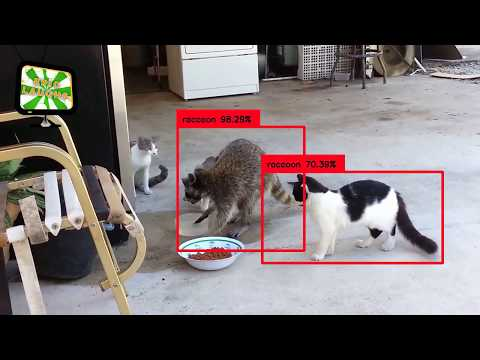

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('lxLyLIL7OsU', width=800, height=300)


In [2]:
# Install the latest ultralytics package
!pip install ultralytics

# Install other required packages
!pip install opencv-python matplotlib pillow seaborn


  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached ultralytics_thop-2.0.13-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 43.2 MB/s eta 0:00:00
Using cached ultralytics_thop-2.0.13-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [3]:
# Import necessary libraries
import torch
from ultralytics import YOLO
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2

### Preparing the Image for Detection
We'll define a function to load and preprocess the image. YOLOv11 expects images in a specific format, but the ultralytics package handles most preprocessing steps internally.

In [4]:
def load_image(image_path):
    """
    Load an image from disk.

    Parameters:
    - image_path (str): Path to the image file.

    Returns:
    - image (PIL.Image): Loaded image.
    """
    image = Image.open(image_path).convert('RGB')
    return image


### Performing Object Detection
Using the loaded model, we'll perform object detection on the image. The ultralytics package handles model inference seamlessly.

In [5]:
def perform_detection(model, image):
    """
    Perform object detection on an image using the YOLOv11 model.

    Parameters:
    - model (YOLO): Loaded YOLOv11 model.
    - image (PIL.Image): Image on which to perform detection.

    Returns:
    - results (ultralytics.yolo.engine.results.Results): Detection results.
    """
    # Perform inference
    results = model(image)

    return results


### Processing and Visualizing the Results
We'll extract bounding boxes, labels, and confidence scores from the detection results and visualize them on the image.


In [6]:
def process_and_visualize(results, image, conf_threshold=0.6, iou_threshold=0.5):
    """
    Process detection results and visualize bounding boxes on the image.

    Parameters:
    - results (ultralytics.yolo.engine.results.Results): Detection results.
    - image (PIL.Image): Original image.
    - conf_threshold (float): Confidence threshold to filter detections.
    - iou_threshold (float): IoU threshold for Non-Max Suppression.

    Returns:
    - None
    """
    # Convert PIL image to numpy array for OpenCV
    image_np = np.array(image)
    
    # Extract detections
    detections = results[0].boxes  # Assuming batch size of 1

    # Iterate through detections
    for det in detections:
        # Get confidence score
        conf = det.conf.item()
        if conf < conf_threshold:
            continue

        # Get class label
        class_id = int(det.cls.item())
        label = results[0].names[class_id]

        # Get bounding box coordinates
        x1, y1, x2, y2 = det.xyxy.tolist()[0]  # [xmin, ymin, xmax, ymax]

        # Draw bounding box
        cv2.rectangle(image_np, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)

        # Prepare label text
        label_text = f"{label} ({conf:.2f})"

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)

        # Draw filled rectangle for text background
        cv2.rectangle(image_np, (int(x1), int(y1) - text_height - 4),
                      (int(x1) + text_width, int(y1)), (255, 255, 255), -1)

        # Put label text above the bounding box
        cv2.putText(image_np, label_text, (int(x1), int(y1) - 2),
                    font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    # Convert back to PIL Image for visualization with matplotlib
    image_with_boxes = Image.fromarray(image_np)

    # Display the image with bounding boxes
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

    # Print detected objects and their scores
    for det in detections:
        conf = det.conf.item()
        if conf < conf_threshold:
            continue
        class_id = int(det.cls.item())
        label = results[0].names[class_id]
        print(f"{label}: {conf * 100:.2f}%")


### Saving Detection Results
To save the images with bounding boxes instead of just displaying them, modify the ```process_and_visualize``` function to save the images.

In [7]:
def process_and_save(results, image, output_path, conf_threshold=0.6, iou_threshold=0.5):
    """
    Process detection results, draw bounding boxes on the image, and save the result.

    Parameters:
    - results (ultralytics.yolo.engine.results.Results): Detection results.
    - image (PIL.Image): Original image.
    - output_path (str): Path to save the output image.
    - conf_threshold (float): Confidence threshold to filter detections.
    - iou_threshold (float): IoU threshold for Non-Max Suppression.

    Returns:
    - None
    """
    # Convert PIL image to numpy array for OpenCV
    image_np = np.array(image)
    
    # Extract detections
    detections = results[0].boxes  # Assuming batch size of 1

    # Iterate through detections
    for det in detections:
        # Get confidence score
        conf = det.conf.item()
        if conf < conf_threshold:
            continue

        # Get class label
        class_id = int(det.cls.item())
        label = results[0].names[class_id]

        # Get bounding box coordinates
        x1, y1, x2, y2 = det.xyxy.tolist()[0]  # [xmin, ymin, xmax, ymax]

        # Draw bounding box
        cv2.rectangle(image_np, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)

        # Prepare label text
        label_text = f"{label} ({conf:.2f})"

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)

        # Draw filled rectangle for text background
        cv2.rectangle(image_np, (int(x1), int(y1) - text_height - 4),
                      (int(x1) + text_width, int(y1)), (255, 255, 255), -1)

        # Put label text above the bounding box
        cv2.putText(image_np, label_text, (int(x1), int(y1) - 2),
                    font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    # Convert back to PIL Image for saving
    image_with_boxes = Image.fromarray(image_np)

    # Save the image with bounding boxes
    image_with_boxes.save(output_path)

    # Print detected objects and their scores
    for det in detections:
        conf = det.conf.item()
        if conf < conf_threshold:
            continue
        class_id = int(det.cls.item())
        label = results[0].names[class_id]
        print(f"{label}: {conf * 100:.2f}%")



0: 416x640 7 elephants, 123.6ms
Speed: 6.2ms preprocess, 123.6ms inference, 121.4ms postprocess per image at shape (1, 3, 416, 640)
elephant: 90.20%
elephant: 88.69%
elephant: 80.94%
elephant: 80.05%
elephant: 71.82%


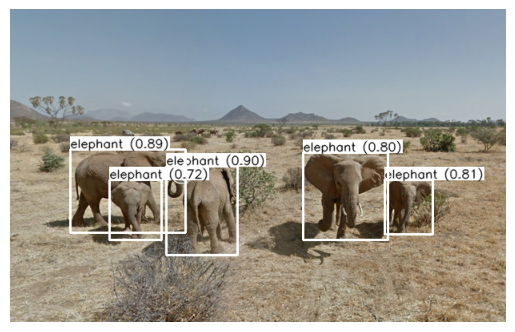

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to the input image
photo_filename = './imgs/test.png'  # Replace with your image path
output_filename = './objdet_output.png'  # Output image path

# Load the image
image = load_image(photo_filename)

# Load the YOLOv11 model
model = YOLO('yolo11n.pt')  # Choose the desired model size

# Perform detection
results = perform_detection(model, image)

# Process and save the results
process_and_save(results, image, output_filename, conf_threshold=0.6, iou_threshold=0.5)

img = mpimg.imread(output_filename)
plt.imshow(img)
plt.axis("off")
plt.show()

## Image segmentation

### Performing Instance Segmentation
Use the loaded model to perform instance segmentation on the image. YOLOv11 provides models specifically tailored for segmentation tasks.


In [9]:
def perform_segmentation(model, image):
    """
    Perform instance segmentation on an image using the YOLOv11 model.

    Parameters:
    - model (YOLO): Loaded YOLOv11 model.
    - image (PIL.Image): Image on which to perform segmentation.

    Returns:
    - results (List[ultralytics.yolo.engine.results.Results]): Segmentation results.
    """
    # Perform inference
    results = model(image)
    return results


### Processing and Visualizing Segmentation Results
Extract segmentation masks, bounding boxes, labels, and confidence scores from the results, and visualize them on the image.

In [10]:
def process_and_visualize_segmentation(results, image, output_path, conf_threshold=0.6):
    """
    Process segmentation results and visualize bounding boxes and masks on the image.

    Parameters:
    - results (List[ultralytics.yolo.engine.results.Results]): Segmentation results.
    - image (PIL.Image): Original image.
    - output_path (str): Path to save the output image.
    - conf_threshold (float): Confidence threshold to filter detections.

    Returns:
    - None
    """
    # Check if there are any detection results
    if not results:
        print("No detections were made.")
        return

    # Access the first result (assuming a single image input)
    detection = results[0]

    # Extract boxes and masks
    boxes = detection.boxes
    masks = detection.masks.data  # List of masks corresponding to each detection

    # Convert PIL image to NumPy array for OpenCV drawing
    image_np = np.array(image)

    # Create an empty mask layer for segmentation visualization
    mask_layer = np.zeros_like(image_np, dtype=np.uint8)

    # Define a color map for different classes
    unique_class_ids = [int(det.cls.item()) for det in boxes if det.conf.item() >= conf_threshold]
    unique_class_ids = list(set(unique_class_ids))
    color_map = {class_id: np.random.randint(0, 255, (3,), dtype=np.uint8).tolist() for class_id in unique_class_ids}

    # Iterate through all detections and corresponding masks
    for det, mask in zip(boxes, masks):
        # Get confidence score
        conf = det.conf.item()
        if conf < conf_threshold:
            continue

        # Get class label
        class_id = int(det.cls.item())
        label = detection.names[class_id]

        # Get bounding box coordinates
        x1, y1, x2, y2 = det.xyxy.tolist()[0]  # [xmin, ymin, xmax, ymax]

        # Binarize the mask (assuming mask is in [0,1] range)
        # Convert PyTorch Tensor to NumPy array before applying astype
        mask_np = (mask > 0.5).cpu().numpy().astype(np.uint8) * 255

        # Assign a unique color to the class
        color = color_map[class_id]

        # Resize mask if necessary
        if mask_np.shape[0] != image.height or mask_np.shape[1] != image.width:
            # Resize mask to match image size
            mask_resized = cv2.resize(mask_np, (image.width, image.height), interpolation=cv2.INTER_NEAREST)
        else:
            mask_resized = mask_np

        # Create a colored mask
        colored_mask = np.zeros_like(image_np, dtype=np.uint8)
        colored_mask[:, :] = color
        colored_mask = cv2.bitwise_and(colored_mask, colored_mask, mask=mask_resized)

        # Combine with the mask layer
        mask_layer = cv2.bitwise_or(mask_layer, colored_mask)

        # Draw bounding box
        cv2.rectangle(image_np, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)

        # Prepare label text
        label_text = f"{label} ({conf:.2f})"

        # Set font parameters
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.5
        font_thickness = 1

        # Calculate text size
        (text_width, text_height), _ = cv2.getTextSize(label_text, font, font_scale, font_thickness)

        # Draw filled rectangle for text background
        cv2.rectangle(image_np, (int(x1), int(y1) - text_height - 4),
                      (int(x1) + text_width, int(y1)), color, -1)

        # Put label text above the bounding box
        cv2.putText(image_np, label_text, (int(x1), int(y1) - 2),
                    font, font_scale, (0, 0, 0), font_thickness, cv2.LINE_AA)

    # Overlay the mask layer on the original image
    image_with_masks = cv2.addWeighted(image_np, 1, mask_layer, 0.5, 0)

    # Convert back to PIL Image for saving
    image_with_boxes_and_masks = Image.fromarray(image_with_masks)

    # Save the image with bounding boxes and segmentation masks
    image_with_boxes_and_masks.save(output_path)

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(image_with_boxes_and_masks)
    plt.axis('off')
    plt.show()

    # Print detected objects and their confidence scores
    for det in boxes:
        conf = det.conf.item()
        if conf < conf_threshold:
            continue
        class_id = int(det.cls.item())
        label = detection.names[class_id]
        print(f"{label}: {conf * 100:.2f}%")

### Instance Segmentation
Combining all the above sections, here's the complete script that performs instance segmentation using YOLOv11 in PyTorch with English comments.

100%|██████████| 5.90M/5.90M [00:00<00:00, 286MB/s]

0: 416x640 6 elephants, 34.8ms
Speed: 1.8ms preprocess, 34.8ms inference, 2.4ms postprocess per image at shape (1, 3, 416, 640)


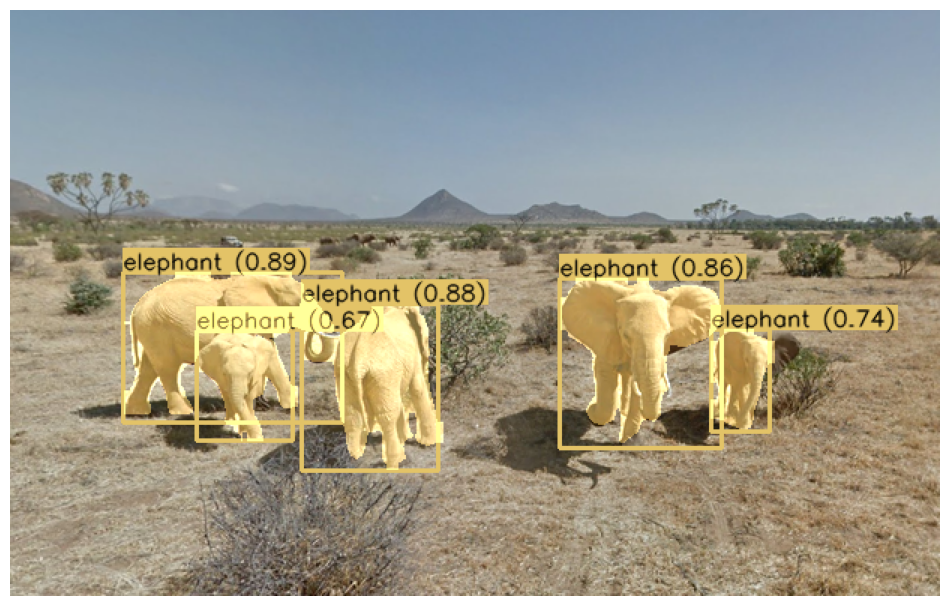

elephant: 88.87%
elephant: 88.20%
elephant: 86.20%
elephant: 73.97%
elephant: 66.55%


In [12]:
# Input image path
photo_filename = 'imgs/test.png'  # Replace with your image path
output_filename = 'objdet_output_seg.png'  # Output image path

# Load the image
image = load_image(photo_filename)

# Load the YOLOv11 instance segmentation model (pre-trained on COCO)
# Choose the desired model size and task type:
# - 'yolov11n-seg.pt': Nano
# - 'yolov11s-seg.pt': Small
# - 'yolov11m-seg.pt': Medium
# - 'yolov11l-seg.pt': Large
# - 'yolov11x-seg.pt': Extra Large
model = YOLO('yolo11n-seg.pt')  # Replace with desired model size and task type

# Move the model to GPU if available
if torch.cuda.is_available():
    model = model.to('cuda')

# Perform instance segmentation
results = perform_segmentation(model, image)

# Process and visualize segmentation results
process_and_visualize_segmentation(results, image, output_filename, conf_threshold=0.6)
